In [1]:
import sys
sys.path.append("..")
import time
from huginn.huginn import Huginn

from huginn.LDA import run_lda

/Users/thomascausero/anaconda3/envs/capstone36/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



In [2]:
cl = Huginn('Steve Jobs')

[{'mid': '/m/06y3r', 'title': 'Steve Jobs', 'type': 'American business magnate'}, {'mid': '/m/012hyvv1', 'title': 'Steve Jobs', 'type': 'Film'}, {'mid': '/m/0h3xrzh', 'title': 'Steve Jobs', 'type': 'Book by Walter Isaacson'}, {'mid': '/m/0j7j4ls', 'title': 'Jobs', 'type': 'Film'}, {'mid': '/m/051dqy7', 'title': 'Steve Jobs', 'type': 'Book by Jeffrey S. Young'}]
Enter the mid you are interested in: /m/06y3r


In [3]:
cl.get_anomalies(k = 1, halflife_std = 10, halflife_mean = 1)

DatetimeIndex(['2007-09-01', '2008-01-01', '2008-06-01', '2009-01-01',
               '2009-06-01', '2010-06-01', '2011-01-01', '2011-02-01',
               '2011-08-01', '2011-10-01'],
              dtype='datetime64[ns]', name='date', freq=None)

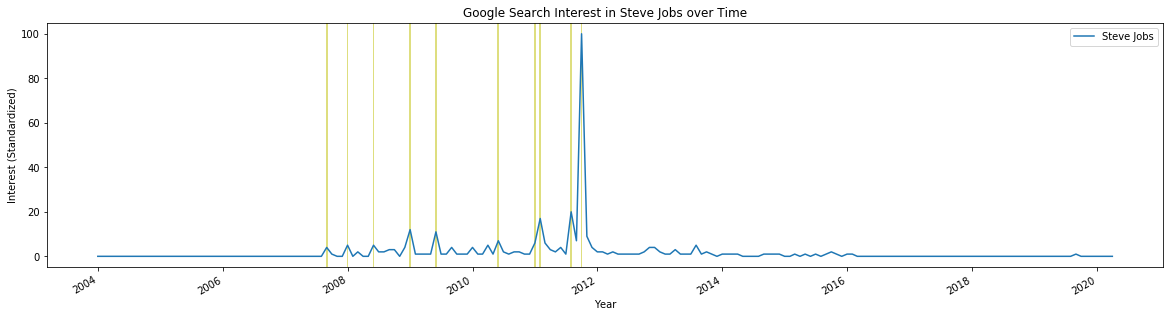


    If you are not happy with these anomalies, you can call the method 'get_anomalies' and
    specify the function to get anomalies:
    - method = 'constant' with parameter k (set to 1 by default)
    - method = 'rolling' with parameters lookback_mean, lookback_std and k (set to 1, 10, 1 by default)
    - method = 'ewm' with parameters halflife_mean, halflife_std and k(set to 1,10,1 by default) [default method]
    


In [5]:
cl.plot_interest_with_anomalies()

In [6]:
cl.get_info()

anomaly n°1: 10 articles were found and 90% were retrieved
anomaly n°2: 7 articles were found and 100% were retrieved
anomaly n°3: 8 articles were found and 62% were retrieved
anomaly n°4: 10 articles were found and 90% were retrieved
anomaly n°5: 10 articles were found and 70% were retrieved
anomaly n°6: 10 articles were found and 80% were retrieved
anomaly n°7: 9 articles were found and 88% were retrieved
anomaly n°8: 10 articles were found and 70% were retrieved
anomaly n°9: 9 articles were found and 66% were retrieved
anomaly n°10: 9 articles were found and 88% were retrieved


In [21]:
dic_info = run_lda(cl.articles, n_components=2, n_words = 5)

In [28]:
date = list(dic_info.keys())[6]
dic_info[date]

[      Topic0  Topic1  dominant_topic
 Doc0    1.00    0.00               0
 Doc1    1.00    0.00               0
 Doc2    1.00    0.00               0
 Doc3    1.00    0.00               0
 Doc4    1.00    0.00               0
 Doc5    0.00    1.00               1
 Doc6    0.01    0.99               1
 Doc7    1.00    0.00               0,            Num Documents
 Topic Num               
 0                      6
 1                      2,            Word 0 Word 1    Word 2   Word 3   Word 4
 Topic 0     apple   jobs      said     cook  company
 Topic 1  renminbi  apple  currency  billion     jobs]

In [37]:
dominant_topic = 0
ids = list(map(lambda x : int(x[3:]), list(
                    df_document_topic[df_document_topic['dominant_topic']==dominant_topic].index)))
data_to_summarize = [articles[i] for i in ids]
len(data_to_summarize)

9

In [38]:
from transformers import pipeline

def run_summary(gpt2_input):
    text_to_summarize = ''.join(gpt2_input)
    summarizer = pipeline("summarization")
    return summarizer(text_to_summarize)

for date in cl.articles.keys():
    print(date,run_summary(cl.articles[date]))

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2007-09-01 00:00:00 [{'summary_text': 'Microsoft, Google and several funds are considering investments in Facebook. Microsoft is considering an investment of $300 million to $500 million for a 5 percent stake. Google is also said to be interested in an investment. Facebook is seeking a minimum valuation of $10 billion but could go as high as $13 billion.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2007-10-01 00:00:00 [{'summary_text': 'An alliance of companies led by Google plans to begin introducing a common set of standards. The strategy is aimed at one-upping Facebook, which last spring opened its service to outside developers. More than 5,000 small programs have been built to run on the Facebook site. For Google, the effort could breathe new life into Orkut.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2008-05-01 00:00:00 [{'summary_text': 'Wen Jiabao has a page on Facebook, one of the most popular sites of its kind. As of early Wednesday, the page had about 13,000 “supporters” It reflects the booming popularity of Mr. Wen, also known as “Grandpa Wen,’ who flew to Sichuan.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2008-10-01 00:00:00 [{'summary_text': 'Facebook is used as a vehicle for nostalgia. There are thousands of alumni associations that provide a virtual, perpetual reunion. For current Park Slopers, the site captures the unusual experience of childhood. Some use the group to settle old scores that reflect a landscape hard to imagine now.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2008-11-01 00:00:00 [{'summary_text': 'Facebook Connect allows members to log onto other Web sites using their Facebook ID. Members can see their friends’ activities on those sites. Connect also gives members the opportunity to broadcast their actions to friends on Facebook. In the next few weeks, a number of prominent Web sites will weave this service into their pages.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2008-12-01 00:00:00 [{'summary_text': 'Thousands of users join fan pages devoted to top Mafia bosses on Facebook. Facebook Connect allows its members to log onto other Web sites using their Facebook ID. Connect also gives members the opportunity to broadcast their actions on those sites to their friends. Facebook wants to make certain the other Web companies do not supplant it.'}]


Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


2009-09-01 00:00:00 [{'summary_text': 'Facebook has been slowly introducing features that mimic Twitter. Users can now “tag” friends or companies that they mention in status updates. Facebook Lite is essentially a stream of updates, which are not available on Twitter. Twitter lets people share updates and links with anyone who cares to read them.'}]
